# Training a custom classifier on top of CNN features

Setting paths and global parameters

*Change **caffe_root** to where your caffe installation is located, and **modelpath** to where you have downloaded the models from ModelZoo*

**modelname** can be changed to more sophisticaded models

In [23]:
# caffe root folder
caffe_root = '/media/tom/TOSHIBA/BigExperiments/Segmentation/caffe'

# folder containing training images
trainingimagepath = './building_images'

# folder containing models
modelpath = '/media/tom/TOSHIBA/BigExperiments/Segmentation/caffe/models/'

# name of model to be used
#modelname = 'bvlc_reference_caffenet' # alexnet equivalent
modelname = 'bvlc_googlenet' # more sophisticated googlenet 

# whether or not to use GPU computation (setting up a GPU will make things A LOT faster)
HASGPU = True #

modelpath += modelname

In [24]:
import sys

# add caffe to path
pycaffepath = caffe_root+'/python'

if caffe_root not in sys.path: sys.path.append(caffe_root)
if pycaffepath not in sys.path: sys.path.append(pycaffepath)

Importing required libraries

In [19]:
import time

# for deep learning
import caffe 
# for the support vector machine classifier
import sklearn
import sklearn.svm
# for maths
import numpy
# for image handling
import PIL
from PIL import Image
# for saving and loading stuff 
import pickle
import glob

Loading pre-trained CNN... (**penultimatelayer** should contain the name of the layer which will be used as the feature representation)

This will take some time

In [17]:
if 'caffenet' or 'alexnet' in modelname:
    penultimatelayer = 'fc8'
else:
    penultimatelayer='pool5/7x7_s1'
protopath = modelpath+'/deploy.prototxt'
cmodelpath = modelpath+'/'+modelname+'.caffemodel'
net = caffe.Classifier(protopath, cmodelpath)

net.set_phase_test()
if HASGPU:
    net.set_mode_gpu()
else:
    net.set_mode_cpu()
net.set_mean('data',numpy.load(caffe_root+'/python/caffe/imagenet/ilsvrc_2012_mean.npy'))
net.set_channel_swap('data',(2,1,0))
net.set_input_scale('data',255)

Loading images and calculating CNN (fc8) features for each image...
Running this may take hours, especially without a good GPU. Feel free to skil running this cell and continue with the next one (which loads the features I precomputed).

Results will be dumped into a file called *modelname+'_building_features.b'*

In [11]:
fnames = sorted(glob.glob(trainingimagepath+'/*.jpg'))
#print fnames
imgfeatures = []
i=0
for f in fnames:
    i+=1
    print i,"/",len(fnames), f
    img = Image.open(f)
    # scale all images to 256x256
    img = img.resize((256,256), PIL.Image.ANTIALIAS)
    img = numpy.array(img).astype(numpy.float32)

    # use CNN to predict (but don't use predicted class)
    p = net.predict([img])
    # obtain features of the specified layer
    feature = net.blobs[penultimatelayer].data
    # save features into array
    imgfeatures.append(feature.flatten())
    
f = open(modelname+'_building_features.b', 'wb')
pickle.dump((fnames, imgfeatures), f)
f.close()

1 / 720 /home/tom/ros/testworld/building_images/Fast Food_0.jpg
2 / 720 /home/tom/ros/testworld/building_images/Fast Food_0_shrink10.jpg
3 / 720 /home/tom/ros/testworld/building_images/Fast Food_0_shrink2.jpg
4 / 720 /home/tom/ros/testworld/building_images/Fast Food_0_shrink3.jpg
5 / 720 /home/tom/ros/testworld/building_images/Fast Food_0_shrink4.jpg
6 / 720 /home/tom/ros/testworld/building_images/Fast Food_0_shrink6.jpg
7 / 720 /home/tom/ros/testworld/building_images/Fast Food_1.jpg
8 / 720 /home/tom/ros/testworld/building_images/Fast Food_10.jpg
9 / 720 /home/tom/ros/testworld/building_images/Fast Food_10_shrink10.jpg
10 / 720 /home/tom/ros/testworld/building_images/Fast Food_10_shrink2.jpg
11 / 720 /home/tom/ros/testworld/building_images/Fast Food_10_shrink3.jpg
12 / 720 /home/tom/ros/testworld/building_images/Fast Food_10_shrink4.jpg
13 / 720 /home/tom/ros/testworld/building_images/Fast Food_10_shrink6.jpg
14 / 720 /home/tom/ros/testworld/building_images/Fast Food_11.jpg
15 / 720 /

Loading CNN features for each building (can be skipped if you just ran the cell above)

In [49]:
f = open(modelname+'_building_features.b', 'rb')
(fnames, imgfeatures) = pickle.load(f)
f.close()
imgfeatures=numpy.array(imgfeatures)

Training a linear SVM

In [51]:
train = True # set to True to re-train the model

In [52]:
imgreps = []

objnames = [] # array with all object names
for f in fnames:
    # object names are parsed from file names (anything after the last slash and before the first underscore)
    obj = f[(f.rfind('/')+1):f.rfind('.')]
    obj = obj[:obj.index('_')]
    objnames.append(obj)
    
# unique object names constitute the classes (8 in this example)
unq_objnames = sorted(list(set(objnames)))

classes = []
for obj in objnames:
    classes.append(unq_objnames.index(obj))
classes = numpy.array(classes, dtype=int)

imgfeatures = numpy.array(imgfeatures)

if not train:
    print "NOT TRAINING. Trying to load previous model"
    with open(modelname+'_trainedsvm.b', 'rb') as f:
        (model, unq_objnames) = pickle.load(f)
else:
    model = sklearn.svm.SVC(kernel="linear", C=1e6, probability=True) # little regularization needed - get this training set right, neglect margin
    model.fit(imgfeatures, classes)
    with open(modelname+'_trainedsvm.b', 'wb') as f:
        pickle.dump((model, unq_objnames), f)

Plot some stuff for illustration

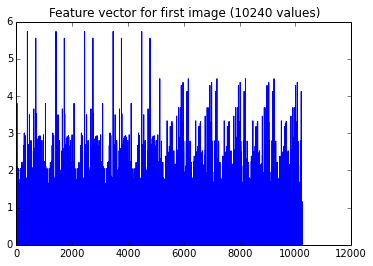

In [36]:
# load plotting functions
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot "feature vector" (activation values of the neurons in the layer we are using as the feature representation) for the first image
f = imgfeatures[0, :]
plt.plot(f)
plt.title('Feature vector for first image ('+str(len(f))+' values)')

In [58]:
model.coef_.shape

(28, 10240)

all object names:
['Fast Food', 'Gas Station', 'House 1', 'House 2', 'House 3', 'Office Building', 'iss', 'osrf']

predicted class of the  0 th image:
[0]
Fast Food

weights (coefficients, decision boundary parameters) of linear SVM for each feature in the feature vectors:


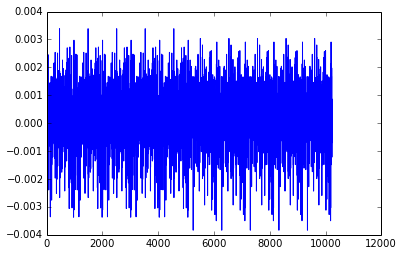

In [59]:
# print unique object names (8 in this example)
print "all object names:"
print unq_objnames

# predict class of first image with SVM
imagenumber = 0
print "\npredicted class of the ", imagenumber, "th image:"

f = imgfeatures[imagenumber, :]
predicted_class = model.predict(f)
print predicted_class
print unq_objnames[predicted_class]

print "\nweights (coefficients, decision boundary parameters) of linear SVM for each feature in the feature vectors:"
x = plt.plot(model.coef_[0, :])

predict the class of a new image using our trained model

In [60]:
newimagepath = './newimage.jpg'
img = Image.open(newimagepath)
# scale to 256x256
img = img.resize((256,256), PIL.Image.ANTIALIAS)
img = numpy.array(img).astype(numpy.float32)
# use CNN to predict (but don't use predicted class)
p = net.predict([img])
# obtain features of the specified layer
f = net.blobs[penultimatelayer].data
# feed features to trained SVM
print "\npredicted class of the ", imagenumber, "th image:"
predicted_class = model.predict(f)
print predicted_class
print unq_objnames[predicted_class]

IOError: [Errno 2] No such file or directory: './newimage.jpg'

evaluate the performance of our model with cross validation

In [42]:
K=5
print "evaluating the performance of our SVM classifier with 5-fold cross validation (random chance baseline: ", str(1.0/len(unq_objnames)),")"

kf = sklearn.cross_validation.KFold(len(classes), n_folds=K)
scores = []
i=0
for train, test in kf:
    print i,"/",K
    i+=1
    model = sklearn.svm.SVC(C=100)#, C=1, gamma=0)
    model.fit(imgfeatures[train, :], classes[train])
    s=model.score(imgfeatures[test, :], classes[test])
    print s
    scores.append(s)
print numpy.mean(scores), numpy.std(scores)

evaluating the performance of our SVM classifier with 5-fold cross validation (random chance baseline:  0.125 )
0 / 5
0.340277777778
1 / 5
0.319444444444
2 / 5
0.3125
3 / 5
0.340277777778
4 / 5
0.368055555556
0.336111111111 0.0194444444444


Experiment with some other C parameters for the SVM in order to try to improve performance (can skip this)

In [65]:
import random
import time
scores=[]
t1=time.time()
for C in [1e-9, 1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9]:
    s = []
    for i in range(5):
        allidx = range(len(classes))
        train = random.sample(allidx, int(len(classes)*0.2))
        test = list(set(allidx).difference(set(train)))
        model = sklearn.svm.SVC(kernel="linear", C=C)
        model.fit(imgfeatures[train, :], classes[train])
        s.append(model.score(imgfeatures[test, :], classes[test]))
    print C," : ",numpy.mean(s), numpy.std(s)
    scores.append(s)
print time.time()-t1

1e-09  :  0.113541666667 0.00447364539122
1000000000.0  :  0.973958333333 0.0128049228574
22.4372332096


Embedding feature representations in 2D for visualization

['Office Building', 'iss', 'Fast Food', 'House 3', 'House 2', 'House 1', 'Gas Station', 'osrf']
720


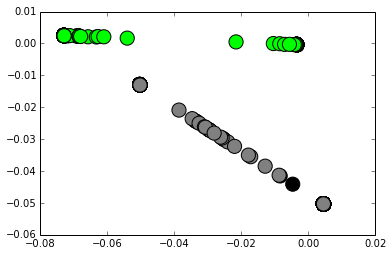

In [45]:
import sklearn.manifold

f = open(modelname+'_building_features.b', 'rb')
(fnames, imgfeatures) = pickle.load(f)
f.close()

objnames = []
for f in fnames:
    obj = f[(f.rfind('/')+1):f.rfind('.')]
    obj = obj[:obj.index('_')]
    objnames.append(obj)

unq_objnames = list(set(objnames))
    
print unq_objnames
print len(imgfeatures)

cols = [(1,0,0), (0,1,0), (0,0,1), (1,1,0), (0,1,1), (1,0,1), (0,0,0), (0.5,0.5,0.5)]
bcols = [0]*len(imgfeatures)
for i in range(len(imgfeatures)):
    bcols[i] = cols[unq_objnames.index(objnames[i])]
    
lle = sklearn.manifold.LocallyLinearEmbedding(n_components=2)
#lle = sklearn.manifold.MDS(n_components=2)
lowdim = lle.fit_transform(imgfeatures)
    
plt.scatter(lowdim[:, 0], lowdim[:, 1], c=bcols, s=200)
plt.show()